## Market Basket Analysis
- Market Basket Analysis is a analysis technique which identifies the strength of association between pairs of products purchased together and identify patterns of co-occurrence.

- Market Basket Analysis creates If-Then scenario rules (association rules), for example, if item A is purchased then item B is likely to be purchased. The rules are probabilistic in nature or, in other words, they are derived from the frequencies of co-occurrence in the observations. Frequency is the proportion of baskets that contain the items of interest. The rules can be used in pricing strategies, product placement, and various types of cross-selling strategies.

- This analysis uses 'Online Retail' data from UCI data collection, and is aimed provide a background on Apriori algorithm, and a practical implementation of the same via Python.

## Apriori Algorithm
- Apriori algorithms is a data mining algorithm used for mining frequent itemsets and relevant association rules. It is devised to operate on a database that contain transactions -like, items bought by a customer in a store.

- An itemset can be considered frequent if it meets a user-specified support threshold. For example, if the support threshold is set to 0.5(50%), a frequent itemset is a set of items that are bought/purchased together in atleast 50% of all transactions.

## Association Rules
- Association rules are a set of rules derived from a database, that can help determining relationship among variables in a large transactional database. It identifies frequent if-then associations, which themselves are the association rules.

- An association rule has two parts: an antecedent (if) and a consequent (then). An antecedent is an item found within the data. A consequent is an item found in combination with the antecedent.

Since multiplie rules are possible even from a very small database, i-order to select the most relevant ones, we use constraints on various measures of interest. The most important measures are discussed below. They are:

### Support  
The Support of an itemset X, supp(X) is the proportion of transaction in the database in which the item X appears. It signifies the popularity of an itemset.

        supp(X) = (Number of transactions in which X appears)/(Total number of transactions)

We can identify itemsets that have support values beyond this threshold as significant itemsets.

### Confidence 
Confidence of a rule signifies the likelihood of item Y being purchased when item X is purchased.

Thus, 
        
        conf(X -> Y) = supp(X *U Y) / supp( X )*

If conf (X -> Y) is 75%, it implies that, for 75% of transactions containing X & Y, this rule is correct. It is more like a conditional probability, P(Y|X), that the probability of finding itemset Y in transactions fiven that the transaction already contains itemset X.

### Lift
Lift explains the the likelihood of the itemset Y being purchased when itemset X is already purchased, while taking into account the popularity of Y.

Thus,
                
        lift (X -> Y) = supp (X *U Y)/( supp(X) * supp (Y) )*

If the value of lift is greater than 1, it means that the itemset Y is likely to be bought with itemset X, while a value less than 1 implies that the itemset Y is unlikely to be bought if the itemset X is bought.

### Conviction
The conviction of a rule can be defined as :

        conv (X->Y) = (1-supp(Y))/(1-conf(X-Y))

If the conviction means 1.4, it means that the rule X -> Y would be incorrect 40% more often if the association between X & Y was an accidental chance

## Environment Set-up

In [3]:
import gc
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import mlxtend.preprocessing
import mlxtend.frequent_patterns

## Data Wrangling

In [4]:
df=pd.read_csv("online_retail.csv")
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [6]:
df.shape

(541909, 8)

In [8]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


## Data Preprocessing

In [9]:
'''
Create an indicator column stipulating whether the invoice number begins with 'C'
'''

df['Is_C_Present'] = (
    df['InvoiceNo']
    .astype(str)
    .apply(lambda x: 1 if x.find('C') != -1 else 0))

df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Is_C_Present
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,0
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,0
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,0
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,0


In [10]:
df.Is_C_Present.value_counts

<bound method IndexOpsMixin.value_counts of 0         0
1         0
2         0
3         0
4         0
         ..
541904    0
541905    0
541906    0
541907    0
541908    0
Name: Is_C_Present, Length: 541909, dtype: int64>

In [11]:
'''
Filter out all transactions having either zero or a negative number of items.
Remove all invoice numbers starting with 'C' (using columns 'Is_C_Present').
Subset the dataframe down to 'InvoiceNo' and 'Descritpion'.
Drop all rows with at least one missing value.
'''


df_clean = (
    df
    # filter out non-positive quantity values
    .loc[df["Quantity"] > 0]
    # remove InvoiceNos starting with C
    .loc[df['Is_C_Present'] != 1]
    # column filtering
    .loc[:, ["InvoiceNo", "Description"]]
    # dropping all rows with at least one missing value
    .dropna()
)

df_clean

,InvoiceNo,Description
0,536365,WHITE HANGING HEART T-LIGHT HOLDER
1,536365,WHITE METAL LANTERN
2,536365,CREAM CUPID HEARTS COAT HANGER
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE
4,536365,RED WOOLLY HOTTIE WHITE HEART.
...,...,...
541904,581587,PACK OF 20 SPACEBOY NAPKINS
541905,581587,CHILDREN'S APRON DOLLY GIRL
541906,581587,CHILDRENS CUTLERY DOLLY GIRL
541907,581587,CHILDRENS CUTLERY CIRCUS PARADE


In [12]:
'''
Transform the data into a list of lists called invoice_item_list

'''

invoice_item_list = []

for num in list(set(df_clean.InvoiceNo.tolist())):
    # filter data set down to one invoice number
    tmp_df = df_clean.loc[df_clean['InvoiceNo'] == num]
    # extract item descriptions and convert to list
    tmp_items = tmp_df.Description.tolist()
    # append list invoice_item_list
    invoice_item_list.append(tmp_items)

print(invoice_item_list[1:3])

[['COLOURING PENCILS BROWN TUBE', 'FIRST CLASS HOLIDAY PURSE ', 'DOORMAT RED RETROSPOT', 'JUMBO BAG WOODLAND ANIMALS', 'JUMBO BAG OWLS', 'WOODLAND CHARLOTTE BAG', 'ROSE DU SUD COSMETICS BAG', 'ROSE DU SUD WASHBAG ', 'ROSE DU SUD DRAWSTRING BAG', 'CREAM SLICE FLANNEL PINK SPOT ', 'RED RETROSPOT PEG BAG', "YOU'RE CONFUSING ME METAL SIGN ", 'SET 3 RETROSPOT TEA,COFFEE,SUGAR', 'SWEETHEART CERAMIC TRINKET BOX', 'STRAWBERRY CERAMIC TRINKET BOX', 'VICTORIAN SEWING BOX SMALL ', 'HOME SMALL WOOD LETTERS', 'RED HEART SHAPE LOVE BUCKET ', 'WHITE SPOT RED CERAMIC DRAWER KNOB', 'EASTER TIN BUCKET', 'CLASSIC FRENCH STYLE BASKET GREEN ', 'CHRISTMAS TREE DECORATION WITH BELL', 'GARLAND WITH HEARTS AND BELLS', 'STAR  T-LIGHT HOLDER ', "IF YOU CAN'T STAND THE HEAT MUG", 'TRADITIONAL WOODEN SKIPPING ROPE', 'PHARMACIE FIRST AID TIN', 'JUMBO STORAGE BAG SKULLS', 'SUKI  SHOULDER BAG', 'PACK OF 60 PINK PAISLEY CAKE CASES', 'MODERN FLORAL STATIONERY SET', 'BOHEMIAN COLLAGE STATIONERY SET', 'MINI CAKE STAND  H

In [13]:
# Initialize and fit the transaction encoder
online_encoder = mlxtend.preprocessing.TransactionEncoder()
online_encoder_array = online_encoder.fit_transform(invoice_item_list)

# Recast the encoded array as a dataframe
online_encoder_df = pd.DataFrame(online_encoder_array, columns=online_encoder.columns_)

# Print the results
online_encoder_df

,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,...,returned,taig adjust,test,to push order througha s stock was,website fixed,wrongly coded 20713,wrongly coded 23343,wrongly marked,wrongly marked 23343,wrongly sold (22719) barcode
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20131,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
20132,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
20133,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
20134,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Association Rules

In [14]:
'''
Run the Apriori Algorithm with min_support = 0.01 (by default 0.5)
'''

apriori_model = mlxtend.frequent_patterns.apriori(online_encoder_df, min_support=0.01)
apriori_model

,support,itemsets
0,0.013359,(8)
1,0.015793,(14)
2,0.012465,(20)
3,0.017630,(21)
4,0.017978,(22)
...,...,...
1849,0.011025,"(1840, 1827, 1837, 1838)"
1850,0.011174,"(2010, 2015, 2014, 2007)"
1851,0.010280,"(2010, 2015, 2020, 2007)"
1852,0.010181,"(2015, 2020, 2014, 2007)"


In [15]:
'''
Run the same model again, but this time with use_colnames=True.
This will replace the numerical designations with the actual item names.
'''

apriori_model_colnames = mlxtend.frequent_patterns.apriori(
    online_encoder_df, 
    min_support=0.01,
    use_colnames=True
)

apriori_model_colnames

,support,itemsets
0,0.013359,( SET 2 TEA TOWELS I LOVE LONDON )
1,0.015793,(10 COLOUR SPACEBOY PEN)
2,0.012465,(12 MESSAGE CARDS WITH ENVELOPES)
3,0.017630,(12 PENCIL SMALL TUBE WOODLAND)
4,0.017978,(12 PENCILS SMALL TUBE RED RETROSPOT)
...,...,...
1849,0.011025,"(JUMBO SHOPPER VINTAGE RED PAISLEY, JUMBO STOR..."
1850,0.011174,"(LUNCH BAG BLACK SKULL., LUNCH BAG CARS BLUE,..."
1851,0.010280,"(LUNCH BAG SUKI DESIGN , LUNCH BAG BLACK SKUL..."
1852,0.010181,"(LUNCH BAG SUKI DESIGN , LUNCH BAG BLACK SKUL..."


In [16]:
'''
Add an additional column to the output of apriori_model_colnames that contains the size of the item set.
This will help with filtering and further analysis. 
'''

apriori_model_colnames['length'] = (
    apriori_model_colnames['itemsets'].apply(lambda x: len(x))
)

apriori_model_colnames

,support,itemsets,length
0,0.013359,( SET 2 TEA TOWELS I LOVE LONDON ),1
1,0.015793,(10 COLOUR SPACEBOY PEN),1
2,0.012465,(12 MESSAGE CARDS WITH ENVELOPES),1
3,0.017630,(12 PENCIL SMALL TUBE WOODLAND),1
4,0.017978,(12 PENCILS SMALL TUBE RED RETROSPOT),1
...,...,...,...
1849,0.011025,"(JUMBO SHOPPER VINTAGE RED PAISLEY, JUMBO STOR...",4
1850,0.011174,"(LUNCH BAG BLACK SKULL., LUNCH BAG CARS BLUE,...",4
1851,0.010280,"(LUNCH BAG SUKI DESIGN , LUNCH BAG BLACK SKUL...",4
1852,0.010181,"(LUNCH BAG SUKI DESIGN , LUNCH BAG BLACK SKUL...",4


### Examine one Case

In [17]:
apriori_model_colnames[
    apriori_model_colnames['itemsets'] == frozenset(
        {'12 PENCIL SMALL TUBE WOODLAND'})]

,support,itemsets,length
3,0.01763,(12 PENCIL SMALL TUBE WOODLAND),1


In [18]:
apriori_model_colnames[
    (apriori_model_colnames['length'] == 2) & 
    (apriori_model_colnames['support'] >= 0.02) &
    (apriori_model_colnames['support'] < 0.021)
]

,support,itemsets,length
836,0.020759,"(ALARM CLOCK BAKELIKE PINK, ALARM CLOCK BAKELI...",2
887,0.020362,"(CHARLOTTE BAG PINK POLKADOT, CHARLOTTE BAG SU...",2
923,0.020610,"(CHARLOTTE BAG SUKI DESIGN, STRAWBERRY CHARLOT...",2
1105,0.020560,"(JUMBO BAG PINK POLKADOT, JUMBO BAG BAROQUE B...",2
1114,0.020908,"(JUMBO BAG BAROQUE BLACK WHITE, JUMBO SHOPPER...",2
1116,0.020957,"(JUMBO STORAGE BAG SUKI, JUMBO BAG BAROQUE BL...",2
1129,0.020560,"(JUMBO BAG ALPHABET, JUMBO BAG RED RETROSPOT)",2
1137,0.020163,"(JUMBO BAG PEARS, JUMBO BAG APPLES)",2
1203,0.020709,"(JUMBO BAG PINK VINTAGE PAISLEY, JUMBO SHOPPER...",2
1218,0.020560,"(JUMBO STORAGE BAG SKULLS, JUMBO BAG RED RETRO...",2


Text(0.5, 1.0, 'Support')

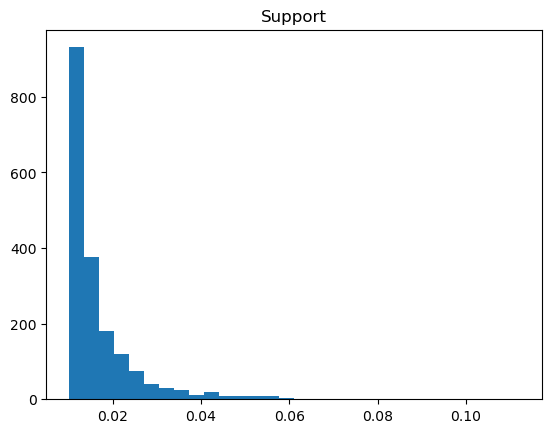

In [19]:
apriori_model_colnames.hist("support", grid=False, bins=30)
plt.title("Support")

## Deriving Association Rules

In [20]:
'''
Generate derive association rules for the online retail dataset.
Here we use confidence as the measure of interestingness.
Set the minimum threshold to 0.6.
Return all metrics, not just support.
'''

rules = mlxtend.frequent_patterns.association_rules(
    apriori_model_colnames, 
    metric="confidence",
    min_threshold=0.6, 
    support_only=False
)

rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(ALARM CLOCK BAKELIKE CHOCOLATE),(ALARM CLOCK BAKELIKE GREEN),0.021255,0.048669,0.013756,0.647196,13.297902,0.012722,2.696488,0.944884
1,(ALARM CLOCK BAKELIKE CHOCOLATE),(ALARM CLOCK BAKELIKE RED ),0.021255,0.052195,0.014501,0.682243,13.071023,0.013392,2.982798,0.943550
2,(ALARM CLOCK BAKELIKE ORANGE),(ALARM CLOCK BAKELIKE GREEN),0.022100,0.048669,0.013558,0.613483,12.605201,0.012482,2.461292,0.941474
3,(ALARM CLOCK BAKELIKE RED ),(ALARM CLOCK BAKELIKE GREEN),0.052195,0.048669,0.031784,0.608944,12.511932,0.029244,2.432722,0.970744
4,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED ),0.048669,0.052195,0.031784,0.653061,12.511932,0.029244,2.731908,0.967146
...,...,...,...,...,...,...,...,...,...,...
493,"(RED RETROSPOT CHARLOTTE BAG, CHARLOTTE BAG SU...","(WOODLAND CHARLOTTE BAG, CHARLOTTE BAG PINK PO...",0.016587,0.019617,0.010131,0.610778,31.135784,0.009806,2.518831,0.984208
494,"(WOODLAND CHARLOTTE BAG, CHARLOTTE BAG PINK PO...","(CHARLOTTE BAG SUKI DESIGN, STRAWBERRY CHARLOT...",0.016140,0.020610,0.010131,0.627692,30.455933,0.009798,2.630593,0.983032
495,"(WOODLAND CHARLOTTE BAG, CHARLOTTE BAG PINK PO...","(RED RETROSPOT CHARLOTTE BAG, STRAWBERRY CHARL...",0.014501,0.024136,0.010131,0.698630,28.945713,0.009781,3.238095,0.979659
496,"(WOODLAND CHARLOTTE BAG, RED RETROSPOT CHARLOT...","(CHARLOTTE BAG PINK POLKADOT, STRAWBERRY CHARL...",0.016687,0.018822,0.010131,0.607143,32.257067,0.009817,2.497544,0.985443


In [21]:
print("Number of Associations: {}".format(rules.shape[0]))

Number of Associations: 498


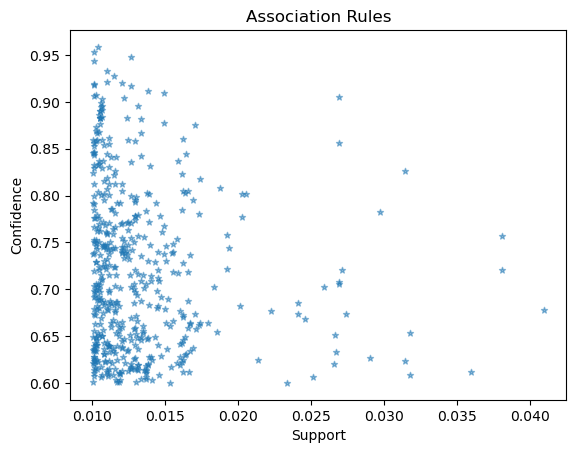

In [22]:
rules.plot.scatter("support", "confidence", alpha=0.5, marker="*")
plt.xlabel("Support")
plt.ylabel("Confidence")
plt.title("Association Rules")
plt.show()

## Summary

### Initial Finding
- There are not any association rules with both extremly high confidence and extremely high support.

- This make sense. If an item set has high support, the items are likely to appear with many other items, making the chances of high confidence very low.

### Conclusion
- With this kind of analysis from the field of mareting you can now determine which products are most often bought in combination with each other. With this knowledge it is possible to arrange the products efficiently in the store. In the best case, products that are often bought together are positioned in the opposite direction in the store so that customers are forced to walk past as many other products as possible.

- Furthermore, one can now consider targeted discount campaigns. If you discount a product that is often bought in combination with others, you increase the chance of buying these products in combination, whereby a small discount is granted on only one.